In [1]:
using Random, Distributions
using LinearAlgebra, Statistics
using CSV, DataFrames
using Plots

In [2]:
# Parameters to choose

γ = 0.2
β = 0.8 # 4% interest rate

ρ = 0.866
σ = 0.059
σ_0 = sqrt(σ^2/(1 - ρ^2)) # 0.12
m = 0.088


m_0 = 0.9
f = 30
c_e = 30



30

In [3]:
# Discretize AR(1) - Tauchen Method

function tauchen(m, σ, ρ=0.866, n_std = 10, N = 60)
    # Discretize space
    m_s = m/(1-ρ)
    σ_s = σ/sqrt(1-ρ^2)
    s_min = m_s - n_std * σ_s
    s_max = m_s + n_std * σ_s
    log_s = range(s_min, s_max, length = N)
    s = exp.(log_s)
    d = log_s[2] - log_s[1]
    d_half = d/2
    
    # Tranformation matrix
    P = zeros(N,N)
    for i in eachindex(log_s) 
        P[i,1] = cdf(Normal(0,1), (s_min + d_half -ρ*log_s[i]-m)/σ)
        P[i,N] = 1 - cdf(Normal(0,1), (s_max - d_half -ρ*log_s[i]-m)/σ)
        for j in 2:N-1
            P[i,j] = cdf(Normal(0,1), (log_s[j] + d_half -ρ*log_s[i]-m)/σ) - cdf(Normal(0,1), (log_s[j]  - d_half -ρ*log_s[i]-m)/σ)
        end    
    end
    return P,s
end

tauchen (generic function with 4 methods)

In [4]:
(P,s) = tauchen(m, σ);

In [5]:
# Find Value Function

function findV_n(p, V0, P, s, fn, f=30, γ=0.2, β=0.8, max_it = 1e4, tol=1e-8)
    i = 1 
    dist = 1e3
    V = V0
    N = length(s)
    
    # optimal q_old
    qo = (p*s).^(1/γ)
    # profit function
    profito = p*qo - (qo.^(1+γ))./((1+γ)*s)-f*ones(N)
    
    # optimal q_new
    qn = (1.2*p*s).^(1/γ)
    # profit function_new
    profitn = p*qn - (qn.^(1+γ))./((1+γ)*s*1.2)-fn*ones(N)
    
    Delta = p^((1+γ)/γ)*s.^(1/γ)*γ/(1+γ)*(1.2^(1/γ))-(fn-f)*ones(N)
    
    profit = zeros(N)
    
    for i in eachindex(s)
        if Delta[i]>0
            profit[i]=profitn[i]
        else
            profit[i]=profito[i]
        end
    end
    
    
    while (i < max_it) & (dist > tol)
        V1 =  max.(0, profit + β * P'*V)
        dist = norm(V1 - V)
        V = V1
        i += 1
    end
    
    return V
    
end

findV_n (generic function with 6 methods)

In [6]:
function fr_entry_n(p, P, s, g, fn, c_e=30)
    V0 = zeros(N)
    V = findV_n(p, V0, P, s, fn)
    return  β*g'*V - c_e
end

fr_entry_n (generic function with 2 methods)

In [7]:
function eqm_price_n(P, s, g, fn, max_it = 1e3, tol=1e-8)
    p_max = 100
    p_min = 0
    v_e = 1e3
    i = 0
    
    while (i < max_it) & (p_max - p_min > tol)
        p = (p_max + p_min)/2
        v_e = fr_entry_n(p, P, s, g, fn)
        if v_e > 0
            p_max = p
        else
            p_min = p
        end
        i +=1
    end
    
    return p_min
end

eqm_price_n (generic function with 3 methods)

In [8]:
# Exit threshold

function exit_s_n(p, s, P, fn, f=30)
    v = -1
    # optimal q_old
    qo = (p*s).^(1/γ)
    # profit function
    profito = p*qo - (qo.^(1+γ))./((1+γ)*s)-f*ones(N)
    
    # optimal q_new
    qn = (1.2*p*s).^(1/γ)
    # profit function_new
    profitn = p*qn - (qn.^(1+γ))./((1+γ)*s*1.2)-fn*ones(N)
    
    Delta = p^((1+γ)/γ)*s.^(1/γ)*γ/(1+γ)*(1.2^(1/γ))-(fn-f)*ones(N)
    
    profit = zeros(N)
    
    for i in eachindex(s)
        if Delta[i]>0
            profit[i]=profitn[i]
        else
            profit[i]=profito[i]
        end
    end
    
    V0 = zeros(N)
    V = profit + β*P'*findV_n(p, V0, P, s,fn)
    
    return sum(V.<0)
end

exit_s_n (generic function with 2 methods)

In [9]:
# moments 

N = length(s)
    
    # Initial distribution
    G = cdf(LogNormal(m_0,σ_0),s)
    g = zeros(N)
    g[1] = G[1]

    for i in 2:N
        g[i] = G[i] - G[i-1]
    end
    g=round.(g/sum(g),digits=4);
    



In [10]:
function findtail(P, s, g, fn)
    price = eqm_price_n(P, s, g, fn) 
    
    # Exit rule
    k = exit_s_n(price,s, P,fn)
    s_star = s[k+1]
    
    P_tilde = zeros(N,N)

    for i in k+1:N
        P_tilde[i,:] = P[i,:]
    end
    
    Delta = price^((1+γ)/γ)*s.^(1/γ)*γ/(1+γ)*(1.2^(1/γ))-(fn-f)*ones(N)
    K_star = sum(Delta.<0)
    
    
    # Invariant distribution
    μ=inv(I-P_tilde')*g
    bar_μ =  μ/sum(μ)
    
    return sum(bar_μ[K_star+1:60])
end

  




findtail (generic function with 1 method)

In [11]:
function findF_n(P, s, g, a, max_it = 1e3, tol=1e-8)
    F_max = 100
    F_min = 30
    #tail = 1e3
    i = 0
    
    while (i < max_it) & (F_max - F_min > tol)
        F = (F_max + F_min)/2
        dist = findtail(P, s, g, F) - a
        if dist > 0
            F_min = F
        else
            F_max = F
        end
        i +=1
    end
    
    return F_min
end

findF_n (generic function with 3 methods)

In [12]:
findF_n(P, s, g, 0.05)

40.13683984405361

In [13]:
findF_n(P, s, g, 0.1)

38.103501732693985

In [14]:
findF_n(P, s, g, 0.2)

35.230907135410234

# Markup

In [15]:
F = zeros(4)

F[1] = 30; F[2] = findF_n(P, s, g, 0.2); F[3] = findF_n(P, s, g, 0.1); F[4] = findF_n(P, s, g, 0.05);


In [16]:
prices = zeros(4)
k_n = zeros(4)

μ = zeros(4,N)
bar_μ = zeros(4,N)
q = zeros(4,N)

rev_ind = zeros(4,N)
rev = zeros(4)
cost_ind = zeros(4,N)
cost =zeros(4)

for i in 1:4
    prices[i] = eqm_price_n(P, s, g, F[i])   
    
    # optimal q_old
    qo = (prices[i]*s).^(1/γ)
    
    # optimal q_new
    qn = (1.2*prices[i]*s).^(1/γ)
    
    Delta = prices[i]^((1+γ)/γ)*s.^(1/γ)*γ/(1+γ)*(1.2^(1/γ))-(F[i]-f)*ones(N)
    
    for j in eachindex(s)
        if Delta[j]>0
            q[i,j]= qn[j]
            cost_ind[i,j] = (qn[i]^(1+γ))/((1+γ)*s[j]*1.2)+F[i]
            rev_ind[i,j] = prices[i]*qn[j]
        else
            q[i,j]=qo[j]
            cost_ind[i,j] = (qo[i]^(1+γ))/((1+γ)*s[j])+f
            rev_ind[i,j] = prices[i]*qo[j]
        end
    end
    
    # Exit rule
    k_n[i] = exit_s_n(prices[i],s, P, F[i])
    x = convert(Int64,k_n[i])
    
    P_tilde = zeros(N,N)
    
    for j in x+1:N
        P_tilde[j,:] = P[j,:]
    end
    
    # Invariant distribution
    μ[i,:]=inv(I-P_tilde')*g
    bar_μ[i,:] =  μ[i,:]/sum(μ[i,:])
    
    
    rev[i] = prices[i]*dot(q[i,:],bar_μ[i,:])
    cost[i] = dot(cost_ind[i,:],bar_μ[i,:])

end

In [17]:
rev ./ cost

4-element Array{Float64,1}:
 0.7812190252554405
 0.5881324371868508
 0.47740419135414036
 0.44186528996415986

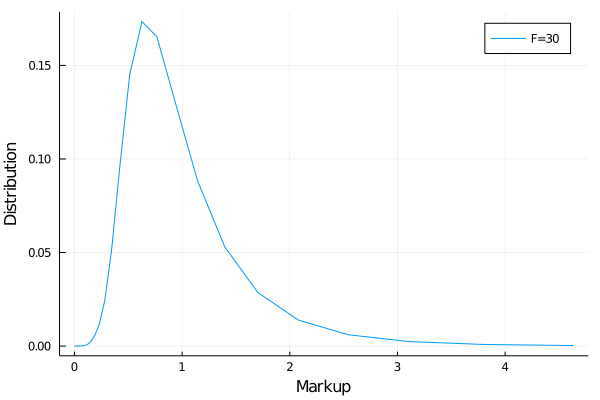

In [18]:
markup = rev_ind ./ cost_ind

# Distribution of markup

plot71 = plot(markup[1,1:47], bar_μ[1,1:47], label = "F=30")
xlabel!("Markup")
ylabel!("Distribution")
#savefig(plot71,"plot7_1.png")

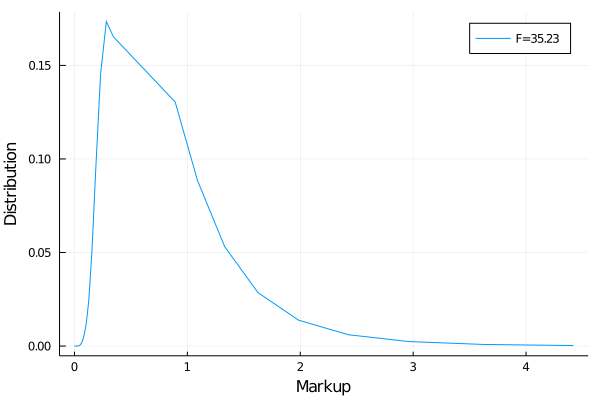

In [19]:
plot72 = plot(markup[2,1:47], bar_μ[2,1:47], label = "F=35.23")
xlabel!("Markup")
ylabel!("Distribution")
#savefig(plot72,"plot7_2.png")

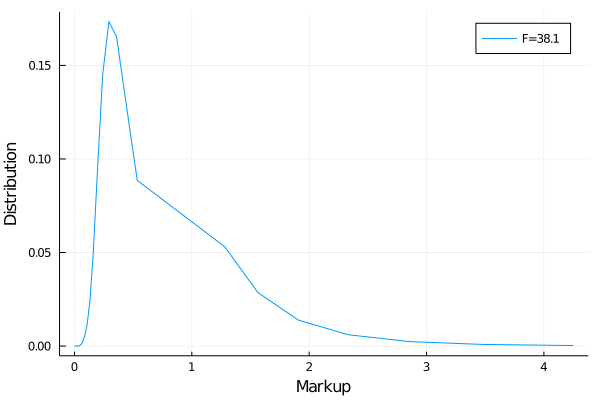

In [20]:
plot73 = plot(markup[3,1:47], bar_μ[3,1:47], label = "F=38.1")
xlabel!("Markup")
ylabel!("Distribution")
#savefig(plot73,"plot7_3.png")

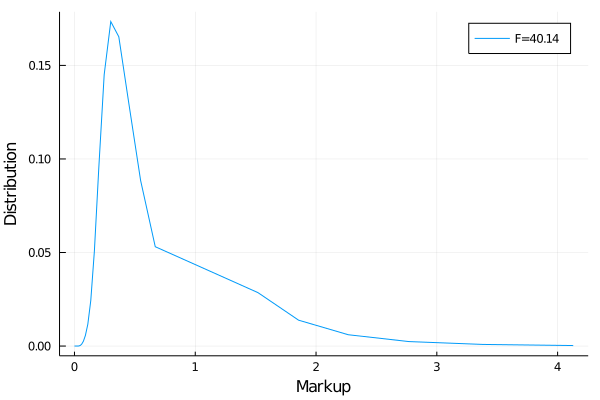

In [21]:
plot74 = plot(markup[4,1:47], bar_μ[4,1:47], label = "F=40.14")
xlabel!("Markup")
ylabel!("Distribution")
#savefig(plot74,"plot7_4.png")

